<a href="https://colab.research.google.com/github/Abigiya-M/Abigiya-M/blob/main/VAE_generativeModeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.datasets import mnist

In [66]:
# ===== Load and Normalize MNIST =====
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

In [67]:
img_shape = x_train.shape[1:]  # (28, 28, 1)
latent_dim = 2

In [68]:
# ===== Encoder =====
encoder_input = layers.Input(shape=img_shape, name='encoder_input')
x = layers.Conv2D(32, 3, padding='same', activation='relu')(encoder_input)
x = layers.Conv2D(64, 3, padding='same', activation='relu', strides=2)(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)

In [69]:
conv_shape = x.shape  # Shape for decoder reshaping
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
z_mu = layers.Dense(latent_dim, name='z_mu')(x)
z_sigma = layers.Dense(latent_dim, name='z_sigma')(x)

In [70]:
# Reparameterization trick
def sampling(args):
    z_mu, z_sigma = args
    epsilon = tf.random.normal(shape=tf.shape(z_mu))
    return z_mu + tf.exp(0.5 * z_sigma) * epsilon

z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mu, z_sigma])

encoder = models.Model(encoder_input, [z_mu, z_sigma, z], name='encoder')
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 28, 28,    │        320 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 14, 14,    │     18,496 │ conv2d_40[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 14, 14,    │     36,928 │ conv2d_41[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 14, 14,    │     36,928 │ conv2d_42[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 12544)     │          0 │ conv2d_43[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 32)        │    401,440 │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mu (Dense)        │ (None, 2)         │         66 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_sigma (Dense)     │ (None, 2)         │         66 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 2)         │          0 │ z_mu[0][0],       │
│                     │                   │            │ z_sigma[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 494,244 (1.89 MB)

 Trainable params: 494,244 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

In [71]:
# ===== Decoder =====
decoder_input = layers.Input(shape=(latent_dim,), name='decoder_input')
x = layers.Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu')(decoder_input)
x = layers.Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu', strides=2)(x)
decoder_output = layers.Conv2DTranspose(1, 3, padding='same', activation='sigmoid', name='decoder_output')(x)

decoder = models.Model(decoder_input, decoder_output, name='decoder')
decoder.summary()


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 12544)          │        37,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_5 (Reshape)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output                  │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,385 (220.25 KB)

 Trainable params: 56,385 (220.25 KB)

 Non-trainable params: 0 (0.00 B)

In [72]:
# ===== VAE = loss via Custom Layer =====
z_decoded = decoder(z)

In [73]:
class CustomLayer(tf.keras.layers.Layer):
    def __init__(self, kl_weight=5e-4, **kwargs):
        super().__init__(**kwargs)
        self.kl_weight = kl_weight

    def vae_loss(self, x, z_decoded, z_mu, z_sigma):
        x_flat = tf.reshape(x, (tf.shape(x)[0], -1))
        z_decoded_flat = tf.reshape(z_decoded, (tf.shape(z_decoded)[0], -1))
        loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.NONE)
        recon_loss = loss_fn(x_flat, z_decoded_flat)
        kl_loss = -0.5 * tf.reduce_sum(1 + z_sigma - tf.square(z_mu) - tf.exp(z_sigma), axis=1)
        total_loss = tf.reduce_mean(recon_loss + self.kl_weight * kl_loss)
        return total_loss

    def call(self, inputs):
        x, z_decoded, z_mu, z_sigma = inputs
        loss = self.vae_loss(x, z_decoded, z_mu, z_sigma)
        self.add_loss(loss)
        return x

In [74]:
# Use encoder_input for model input
y = CustomLayer()([encoder_input, z_decoded, z_mu, z_sigma])
vae = models.Model(encoder_input, y, name="vae")
vae.compile(optimizer='adam', run_eagerly=True)
vae.summary()

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 28, 28,    │        320 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 14, 14,    │     18,496 │ conv2d_40[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 14, 14,    │     36,928 │ conv2d_41[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 14, 14,    │     36,928 │ conv2d_42[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 12544)     │          0 │ conv2d_43[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 32)        │    401,440 │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mu (Dense)        │ (None, 2)         │         66 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_sigma (Dense)     │ (None, 2)         │         66 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 2)         │          0 │ z_mu[0][0],       │
│                     │                   │            │ z_sigma[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 28, 28, 1) │     56,385 │ z[0][0]           │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ custom_layer_12     │ (None, 28, 28, 1) │          0 │ encoder_input[0]… │
│ (CustomLayer)       │                   │            │ decoder[0][0],    │
│                     │                   │            │ z_mu[0][0],       │
│                     │                   │            │ z_sigma[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 550,629 (2.10 MB)

 Trainable params: 550,629 (2.10 MB)

 Non-trainable params: 0 (0.00 B)

In [75]:
# ===== Train the VAE =====
vae.fit(x_train, epochs=10, batch_size=128, validation_split=0.1)

Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 307s 727ms/step - loss: 0.3328 - val_loss: 0.2213
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 323s 729ms/step - loss: 0.2197 - val_loss: 0.2123
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 320s 725ms/step - loss: 0.2091 - val_loss: 0.1994
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 319s 717ms/step - loss: 0.1991 - val_loss: 0.1941
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 323s 719ms/step - loss: 0.1941 - val_loss: 0.1900
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 306s 725ms/step - loss: 0.1909 - val_loss: 0.1885
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 322s 725ms/step - loss: 0.1892 - val_loss: 0.1861
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 322s 725ms/step - loss: 0.1873 - val_loss: 0.1850
Epoch 9/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 319s 717ms/step - loss: 0.1855 - val_loss: 0.1837
Epoch 10/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 323s 720ms/step - loss: 0.1848 - val_loss: 0.1825


313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step


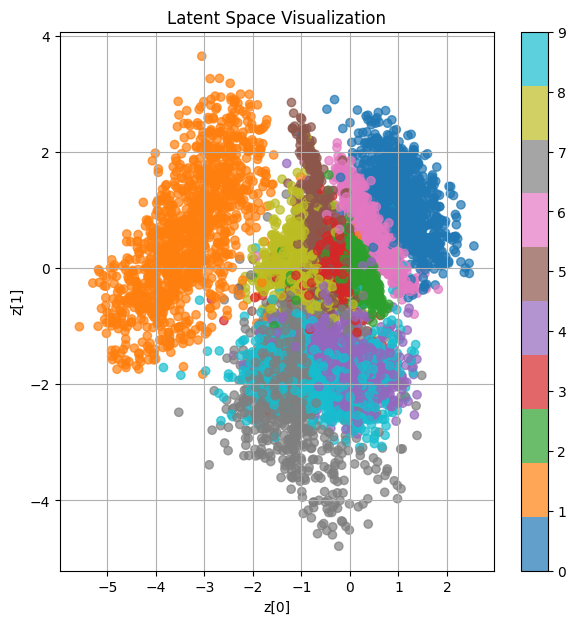

In [77]:
# ===== Visualize Latent Space =====
z_means, _, _ = encoder.predict(x_test)
plt.figure(figsize=(7, 7))
plt.scatter(z_means[:, 0], z_means[:, 1], c=y_test, cmap='tab10', alpha=0.7)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.colorbar()
plt.title("Latent Space Visualization")
plt.grid(True)
plt.show()

In [80]:
def generate_and_plot_images(decoder, n=15, range_lim=3):
    """Generates n x n images from latent space grid."""
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))

    # Linearly spaced coordinates on the 2D latent space
    grid_x = np.linspace(-range_lim, range_lim, n)
    grid_y = np.linspace(-range_lim, range_lim, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])  # shape (1, 2)
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(7, 7))
    plt.imshow(figure, cmap='gray')
    plt.axis('off')
    plt.title('Generated digits from 2D latent space')
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━

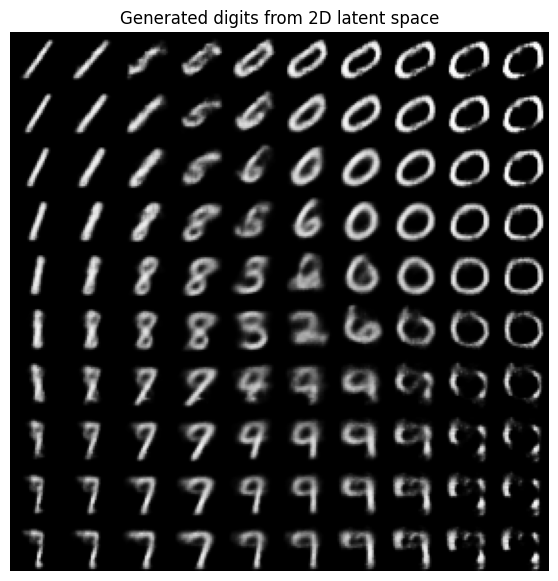

In [81]:
generate_and_plot_images(decoder, n=10)

In [82]:
def show_reconstructed_images(vae, x_test, n=10):
    """Shows original and reconstructed images side-by-side."""
    decoded_imgs = vae.predict(x_test[:n])

    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].squeeze(), cmap='gray')
        plt.title("Original")
        plt.axis("off")

        # Reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].squeeze(), cmap='gray')
        plt.title("Reconstructed")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


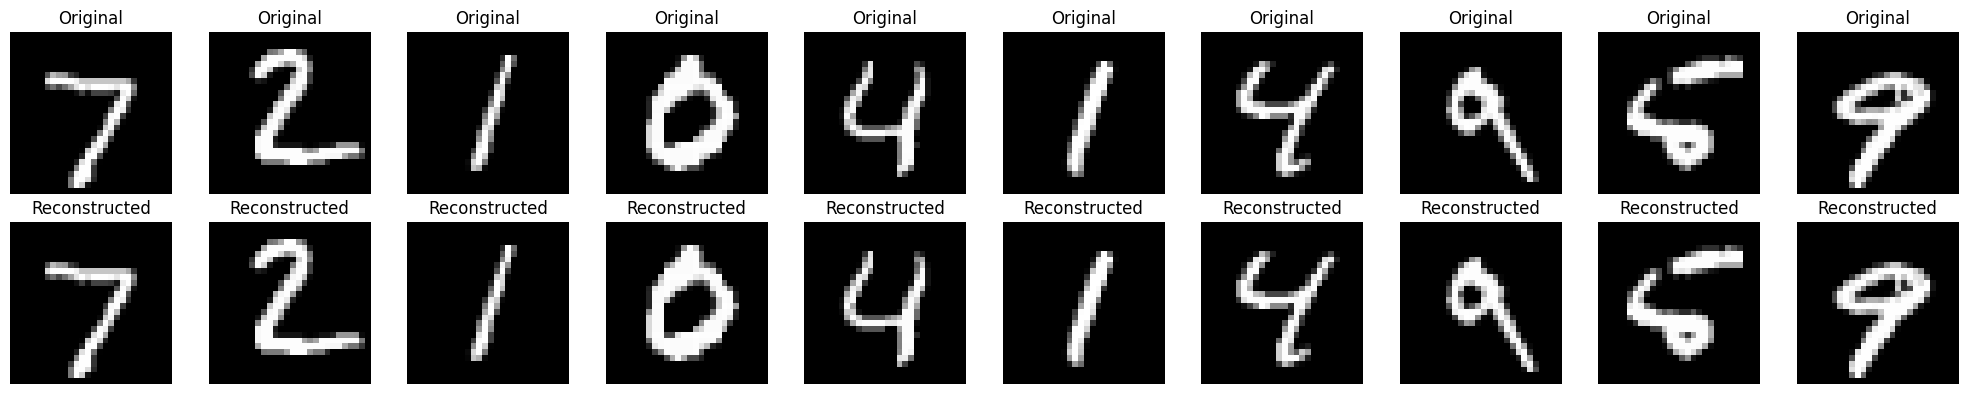

In [83]:
show_reconstructed_images(vae, x_test)

In [84]:
history = vae.fit(x_train, epochs=10, batch_size=128, validation_split=0.1)

Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 301s 711ms/step - loss: 0.1843 - val_loss: 0.1819
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 321s 710ms/step - loss: 0.1835 - val_loss: 0.1817
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 327s 722ms/step - loss: 0.1817 - val_loss: 0.1812
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 330s 741ms/step - loss: 0.1812 - val_loss: 0.1806
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 305s 723ms/step - loss: 0.1810 - val_loss: 0.1799
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 320s 720ms/step - loss: 0.1806 - val_loss: 0.1799
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 319s 713ms/step - loss: 0.1800 - val_loss: 0.1796
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 320s 709ms/step - loss: 0.1796 - val_loss: 0.1798
Epoch 9/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 324s 713ms/step - loss: 0.1791 - val_loss: 0.1789
Epoch 10/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 324s 718ms/step - loss: 0.1786 - val_loss: 0.1788


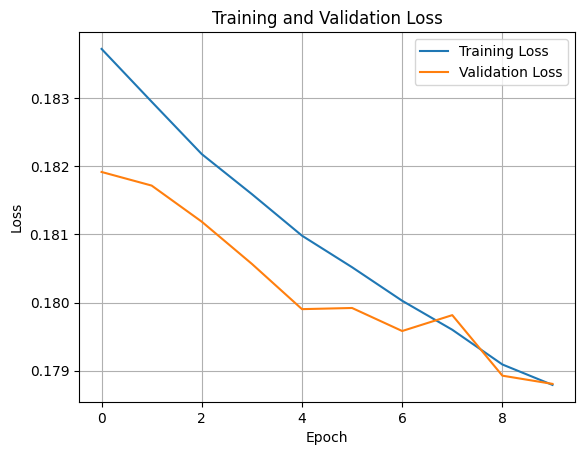

In [85]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss(history)
